Výpočet tepové frekvence

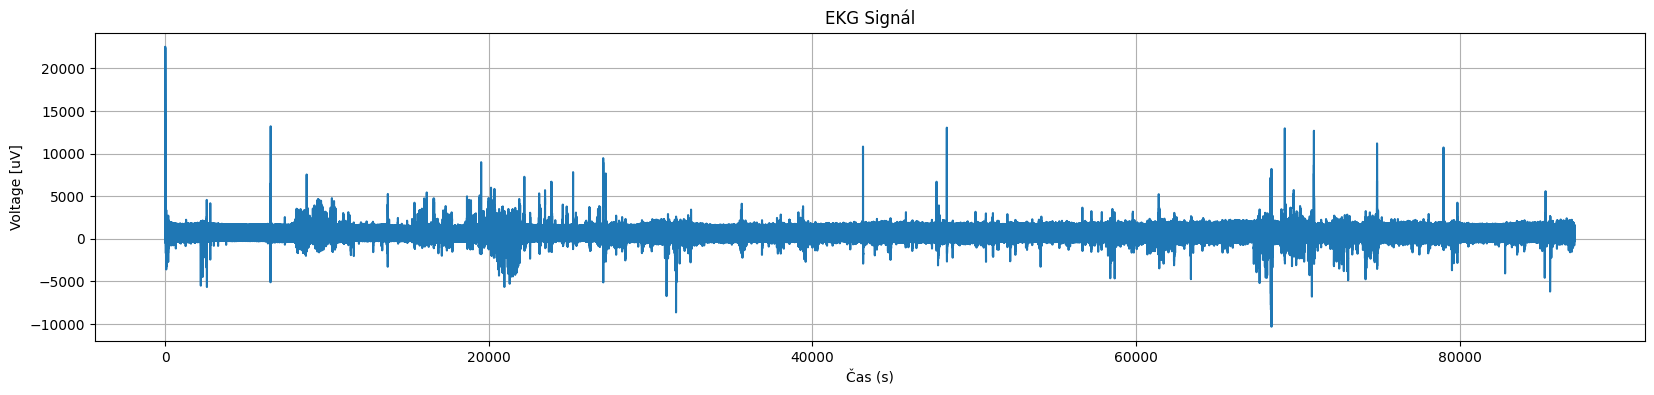

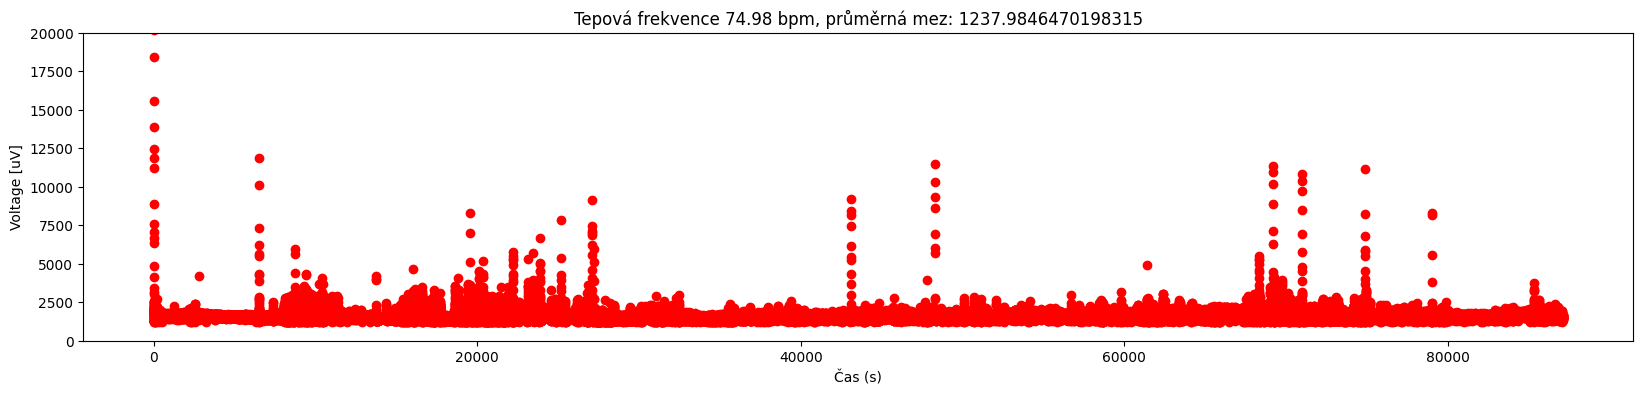

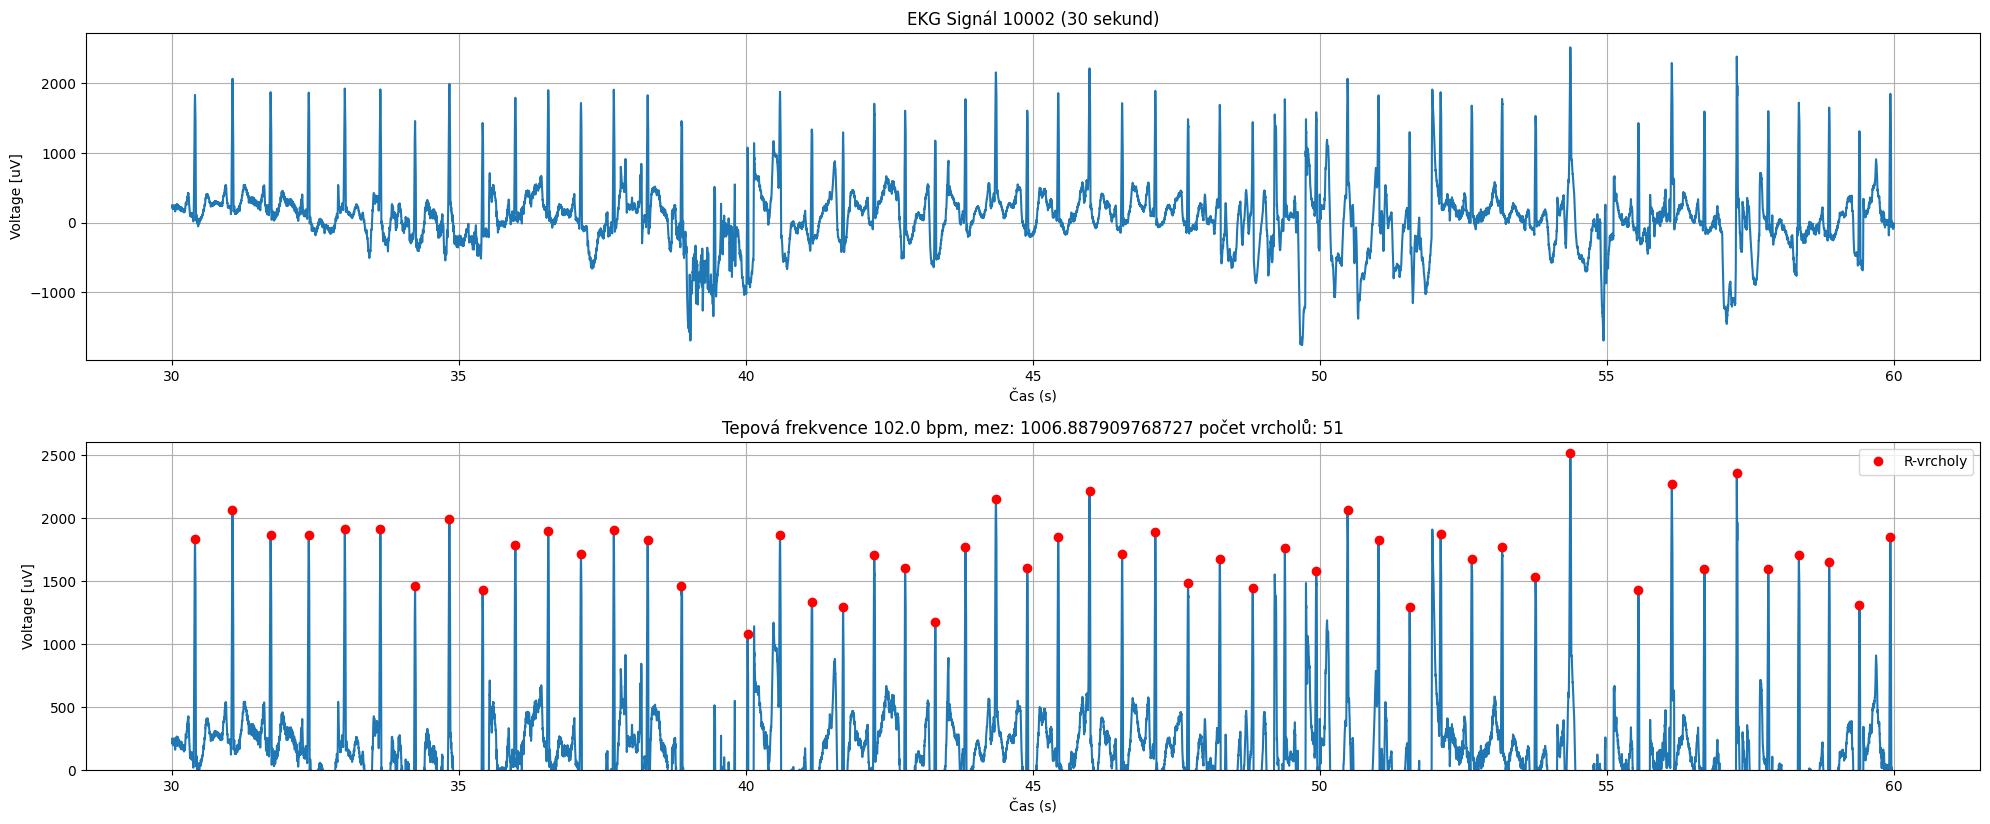

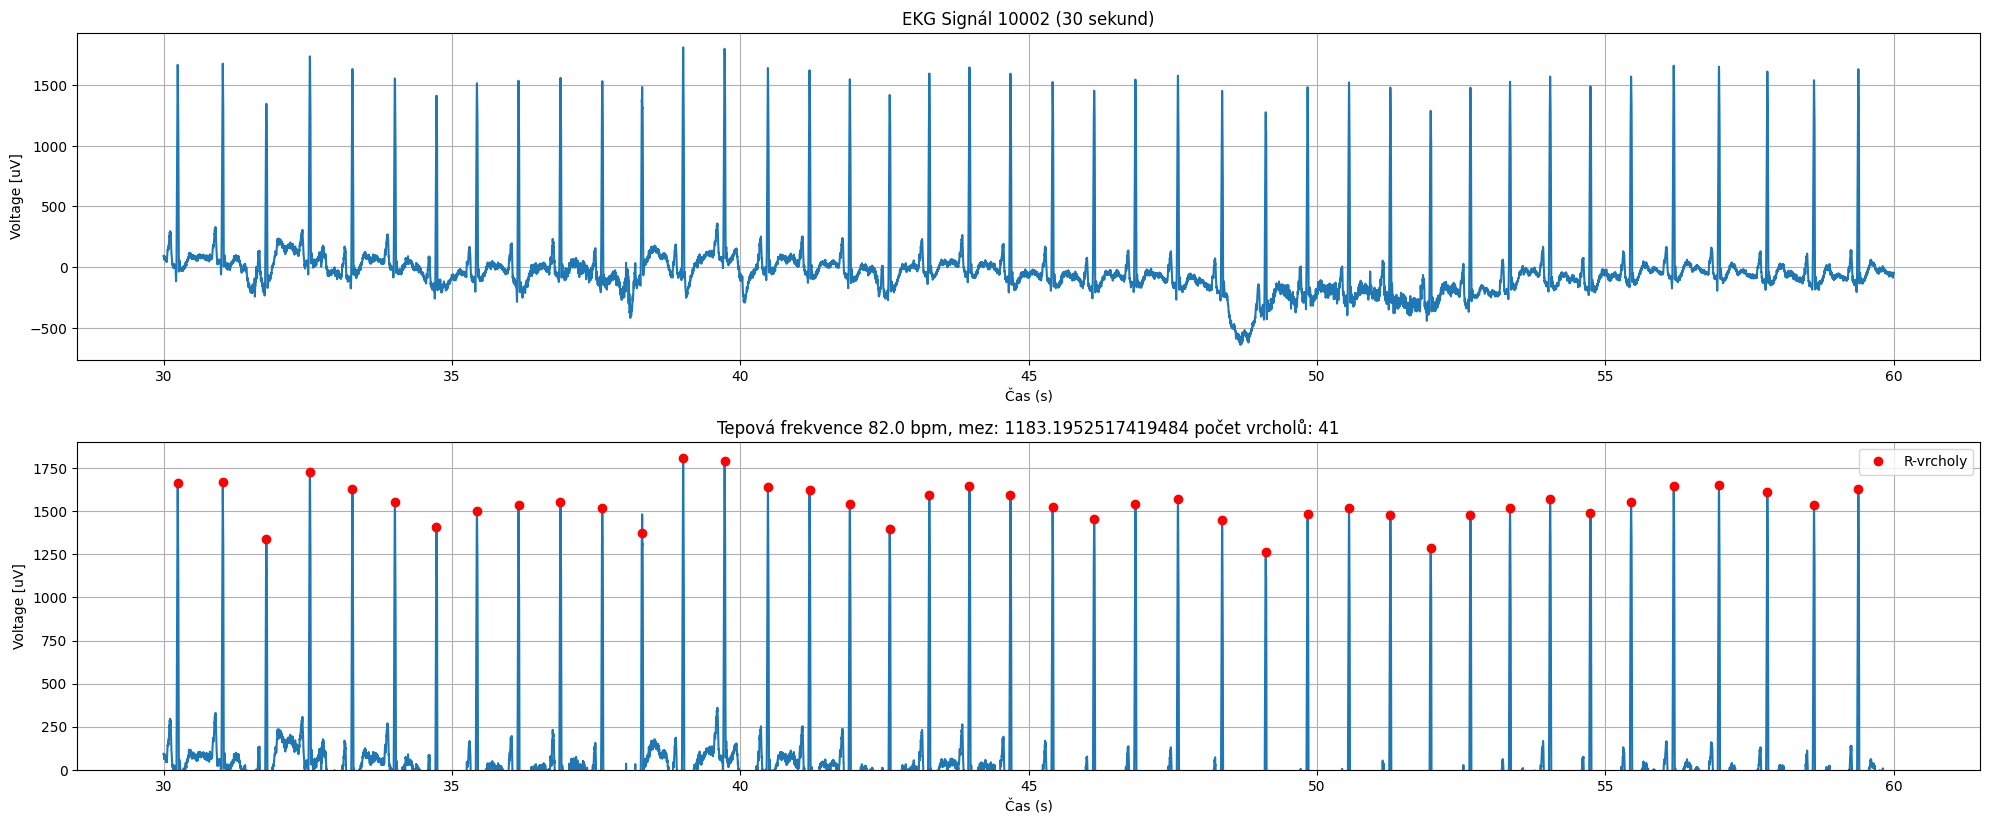

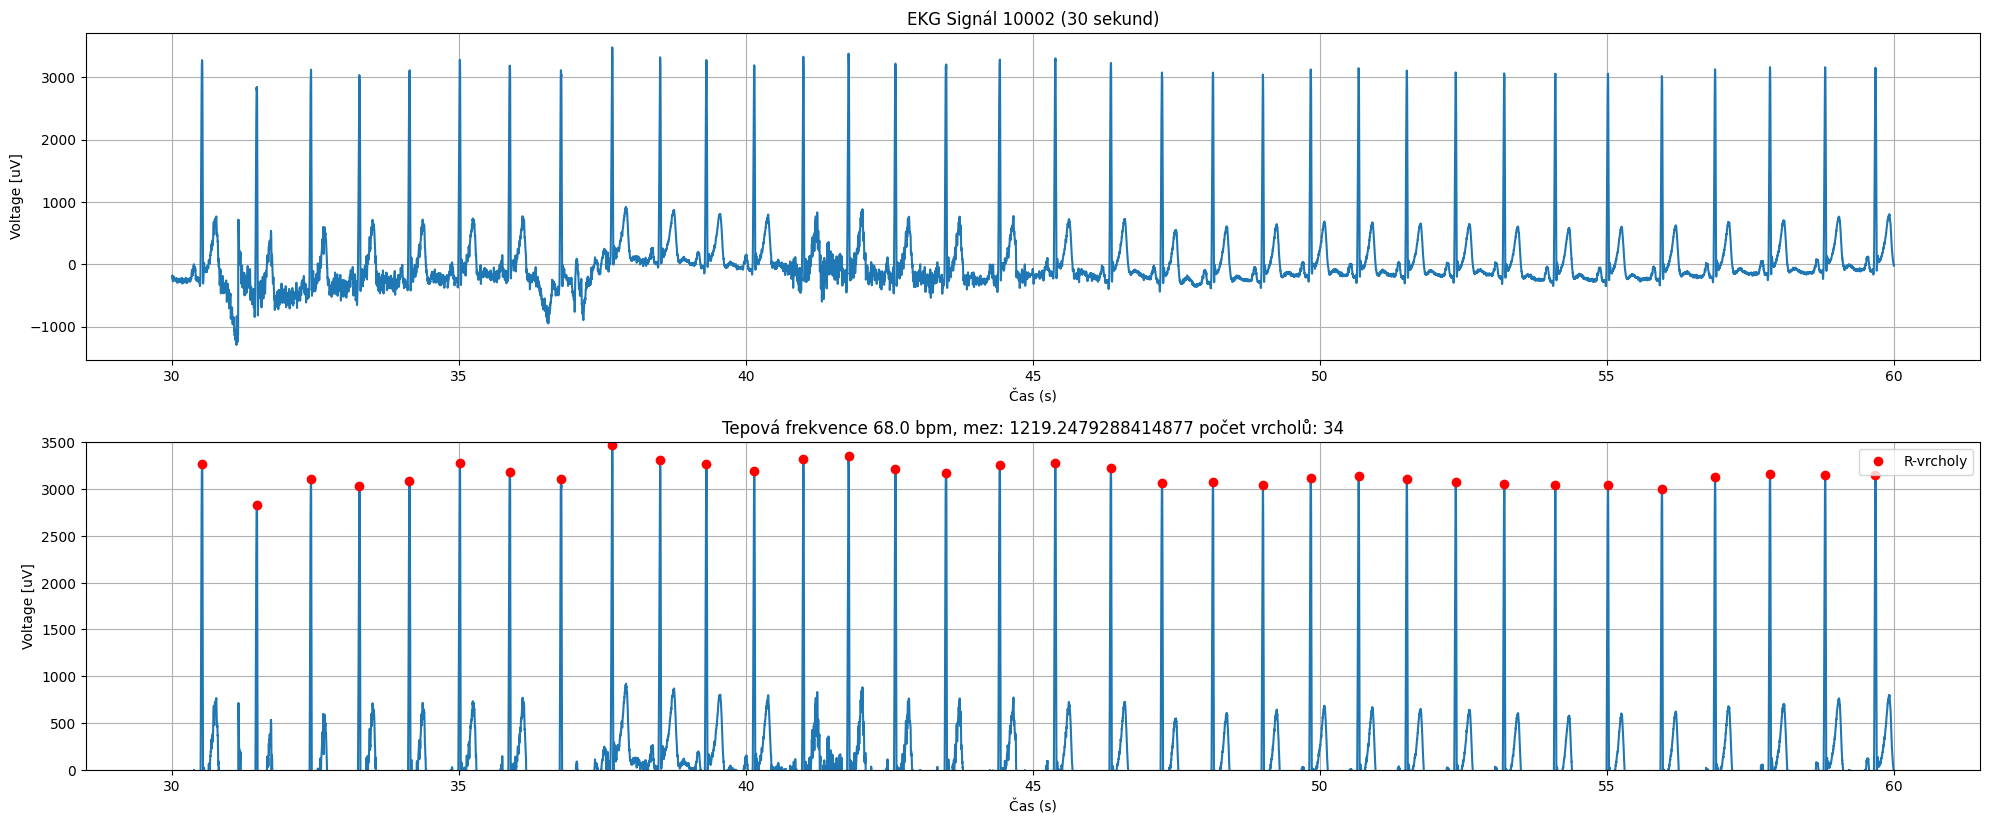

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

#algoritmus pro detekci R vrcholů v signálech + prezentace tepové frekvence při jednotlivých měřeních
def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

# nejdřív si načtu jednotlivá měření, abych věděl, jak to vypadá
ecg_mereni = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\100001\100001_ECG")
#print("Informace o EKG měření:", ecg_mereni.__dict__) 

#vezmu si ze souboru jednotlivé signály
ecg_signal = ecg_mereni.p_signal 
#print(ecg_signal[::50]) #testování
vz_f = ecg_mereni.__dict__['fs'] #vemu si vzorkovací frekvenci měření
time = len(ecg_signal)/vz_f #vypočítáme celkový čas měření
time_axis = np.linspace(0, time, len(ecg_signal)) #uděláme si časovou osu měření
plt.figure(figsize=(20, 4))
plt.plot(time_axis,ecg_signal)
plt.title("EKG Signál")
plt.xlabel("Čas (s)")
plt.ylabel("Voltage [uV]")
plt.grid()
plt.show() #!se dlouho načítá!

def Vypocet_prumerne_frekvence(amplitudy, dolni_mez):
    x_coords = [uV for uV in amplitudy if uV > dolni_mez] #vezmu všechny hodnoty frekvencí, které jsou delší než dolní mez frekvence
    if len(x_coords) > 0: #když měření bude obsahovat nějaké souřadnice
        prumer_x = sum(x_coords) / len(x_coords) #vypočítám si průměrnou hodnotu x vrcholů
        return prumer_x
    else: return 0

#určím si parametry pro výpočet
amplitudy = ecg_signal[:, 0] #vezmu si hodnoty frekvencí z měření
dolni_mez = 500 #určím si dolní mez pro frekvence 1000Uv?
prumer_x = Vypocet_prumerne_frekvence(amplitudy, dolni_mez)

#nyní si vytvořím algoritmus na detekci r vrcholů
def r_peaks_finder(ecg_signal, min_peaks_height, min_distance,test=False):
    r_peaks = [] #seznam, kam si uložím souřadnice vrcholů
    for i in range(1, len(ecg_signal)-1):
        #if ekg_signal[i] > threshold and ekg_signal[i] > ekg_signal[i - 1] and ekg_signal[i] > ekg_signal[i + 1]: peaks.append(i)
        if ecg_signal[i]>min_peaks_height:
            #zkontroluji že hodnota je větší něž okolní hodnoty
            #zde jsem ještě musel přidat podmínku aby to ty vrcholi kontrolovalo o 1 navíc citlivěji, protože mi některé to vynechalo
            if ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+1] or ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+2]:
                if len(r_peaks) == 0 or (i-r_peaks[-1]>=min_distance): 
                    r_peaks.append(i)
                elif test: print(f"Vrchol ignorován (příliš blízko): Index {i}, Hodnota {ecg_signal[i]}")
            elif test: print(f"Vrchol ignorován (není lokální maximum): Index {i}, Hodnota {ecg_signal[i]}")
    #print(r_peaks[:20]) #testování
    return r_peaks

min_peaks_height = prumer_x #zvolím si minimální výšku vrcholů, která je ideální dané ekg
min_distance = int(vz_f*0.5) #minimální vzdálenost mezi vrcholi bude vzorkovací frekvence
r_peaks = r_peaks_finder(ecg_signal,min_peaks_height, min_distance)

#r_peaks_hodnoty = [ecg_signal[i] if i in r_peaks else None for i in range(len(ecg_signal))]

def hearth_beat(r_peaks,start_time,end_time):
    return((len(r_peaks)*60) / (end_time-start_time)) #výpočet tepové frekvence v BPM ((soucet r vrcholu*60/cas)

#Fyziologické hodnoty tepové frekvence se v klidu pohybují od 55 do 90 stahů za minutu.
#pomalejší frekvenci (< 55 tepů/min) označíme jako bradykardii → bradyarytmie,
#rychlejší (> 90 tepů/min) označíme jako tachykardii → tachyarytmie.
tepova_f = hearth_beat(r_peaks,start_time=0,end_time=time)

#tady jsem spočítal graf s všemi R-vrcholi z celého měření, kde mi vyšel průměrná tepová frekvence něco kolem 74, jelikož je měření dlouhé tak se to nebude moc dát rozeznat
plt.figure(figsize=(20,4))
plt.plot([time_axis[i] for i in r_peaks],[ecg_signal[i] for i in r_peaks], linestyle='None', marker='o', color='red', label="R-vrcholy")
plt.title(f"R vrcholy z EKG Signálu")
plt.xlabel("Čas (s)")
plt.ylabel("Voltage [uV]")
plt.title(f"Tepová frekvence {round(tepova_f,2)} bpm, průměrná mez: {prumer_x}")
plt.ylim([0,20000]) #nastavím si x od 0 do 20000
plt.show() #!se dlouho načítá! (potřebuje minimálně 16gb ram)

#vykreslím si časovou mez 1 minutu ze vzorku jelikož záznam je moc dlouhý ma přes 80000s, protože normálně by srdce mělo být 60-100 krát za minutu. Teď by měl být lépe vidět srdeční tep
start_time = 30
end_time = 60
start_index = int(vz_f*start_time) #vezmu si 30 sekund
end_index = int(vz_f*end_time)
ecg_signal_30_60 = amplitudy[start_index:end_index]
time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) #na začátku vidím nějakou anomálii, tak si signál přesunu o 30 sekund dopředu


dolni_mez = 500 #určím si dolní mez pro frekvence 1000Uv?
prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez) #spočítám si výšku pro odchytávání vrcholů
min_peaks_height = prumer_f #zvolím si minimální výšku vrcholů, která je ideální dané ekg
min_distance = int(vz_f*0.5) #minimální vzdálenost mezi vrcholi bude vzorkovací frekvence, kterou když si vynásobím 0.5, tak jí snížim na 500 ms

r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance)

tepova_f = hearth_beat(r_peaks_30_60,start_time,end_time)

#jelikož měření budu zkoušet na více signálu, tak si vykreslování dám do funkce kam mi bude vstupovat signál s časovou osou a vrcholy
def plot_signal(time_axis, ecg_signal, r_peaks, prumer_f):
    from math import ceil
    plt.figure(figsize=(20,12))
    plt.subplot(3, 1, 1)
    plt.plot(time_axis,ecg_signal) #na této ose se již dá vidět lépe srdeční tep
    plt.title("EKG Signál 10002 (30 sekund)")
    plt.xlabel("Čas (s)")
    plt.ylabel("Voltage [uV]")
    plt.grid()
    plt.subplot(3, 1, 2)
    plt.plot(time_axis,ecg_signal)
    plt.plot([time_axis[i] for i in r_peaks],[ecg_signal[i] for i in r_peaks], linestyle='None', marker='o', color='red', label="R-vrcholy")
    plt.title("R vrcholy z EKG Signálu (30 sekund)")
    plt.xlabel("Čas (s)")
    plt.ylabel("Voltage [uV]")
    plt.ylim([0,ceil(max(ecg_signal)/100)*100]) #pomocí funkce ceil spočítám přibližnou hodnotu na kterou by se měla maximální hodnota v grafu zaokrouhlit
    plt.title(f"Tepová frekvence {round(tepova_f,2)} bpm, mez: {prumer_f} počet vrcholů: {len(r_peaks)}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_signal(time_axis_30_60,ecg_signal_30_60,r_peaks_30_60, prumer_f)


#načtu si další signál
ecg_mereni = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\100002\100002_ECG")

ecg_signal = ecg_mereni.p_signal 
vz_f = ecg_mereni.__dict__['fs']
amplitudy = ecg_signal[:, 0]

start_time = 30
end_time = 60
start_index = int(vz_f*start_time)
end_index = int(vz_f*end_time)
ecg_signal_30_60 = amplitudy[start_index:end_index]
time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) 

dolni_mez = 500 
prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez)
min_peaks_height = prumer_f 
min_distance = int(vz_f*0.5) 

r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance)

tepova_f = hearth_beat(r_peaks_30_60,start_time,end_time)

plot_signal(time_axis_30_60,ecg_signal_30_60,r_peaks_30_60, prumer_f)

#vyzkouším to pro další signál
ecg_mereni = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\103001\103001_ECG")
ecg_signal = ecg_mereni.p_signal 
vz_f = ecg_mereni.__dict__['fs']
amplitudy = ecg_signal[:, 0] 

start_time = 30
end_time = 60
start_index = int(vz_f*start_time)
end_index = int(vz_f*end_time)
ecg_signal_30_60 = amplitudy[start_index:end_index]
time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) 

dolni_mez = 500 
prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez)
min_peaks_height = prumer_f 
catching_time = 0.5
min_distance = int(vz_f*catching_time) 

r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance)
tepova_f = hearth_beat(r_peaks_30_60,start_time,end_time)

plot_signal(time_axis_30_60,ecg_signal_30_60,r_peaks_30_60, prumer_f)
